# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [4]:
!pip install SimpleITK 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 30.8 MB/s eta 0:00:00


### Downloading the data

In [5]:
!wget https://www.dropbox.com/s/xdkavdkqljhco2r/brainage-data.zip
!unzip brainage-data.zip

--2023-02-27 18:59:06--  https://www.dropbox.com/s/xdkavdkqljhco2r/brainage-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xdkavdkqljhco2r/brainage-data.zip [following]
--2023-02-27 18:59:07--  https://www.dropbox.com/s/raw/xdkavdkqljhco2r/brainage-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0a6872d7ddcca5c19ab875febd.dl.dropboxusercontent.com/cd/0/inline/B3SIuXGOxZ5dUdKGYIDeElRa7szn6N_CwBopslVPPbjDXcFX75LDzqo5CX0Hgb7i6GmKru335cYrBkReNsZe80RvCWxrY5rzZKL4J7xMAfTWmvETHBjJYG-O-5JbNZMDFAwCzI2TDcQED8gFU9QNSu8ktuWSFKNhCZ9gZMpm65HhcA/file# [following]
--2023-02-27 18:59:07--  https://uc0a6872d7ddcca5c19ab875febd.dl.dropboxusercontent.com/cd/0/inline/B3SIuXGOxZ5dUdKGYIDeElRa7szn6N_CwBopslVPPbjDXcFX75LDzqo5CX0Hgb7i6

### Setting data directory

In [6]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [7]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

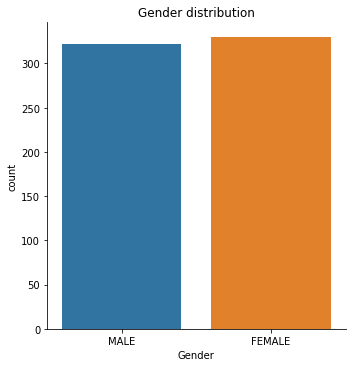

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


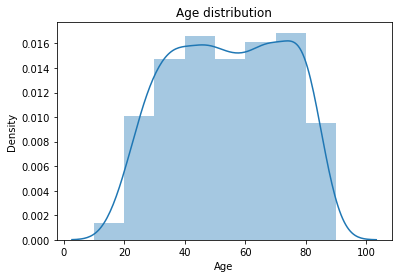

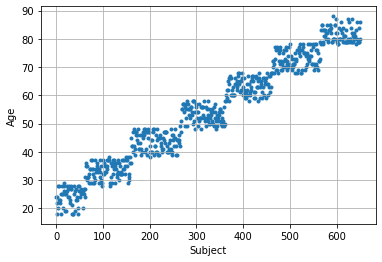

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [9]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


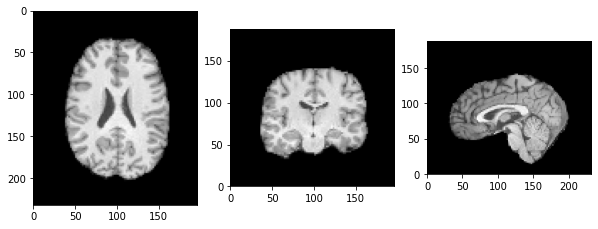

Brain mask


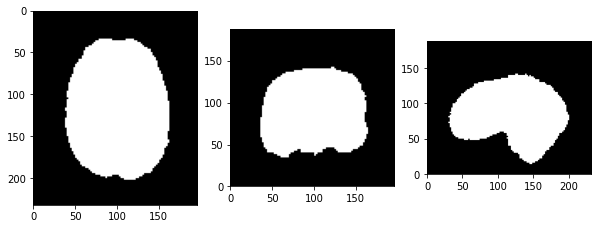

In [10]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [12]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [13]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: NVIDIA A100-SXM4-40GB


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [14]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 30
learning_rate = 0.001
batch_size = 2
val_interval = 5

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [15]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [16]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  9.57it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


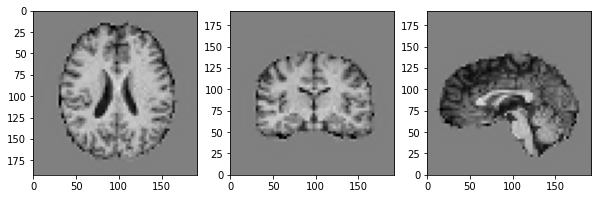

Segmentation


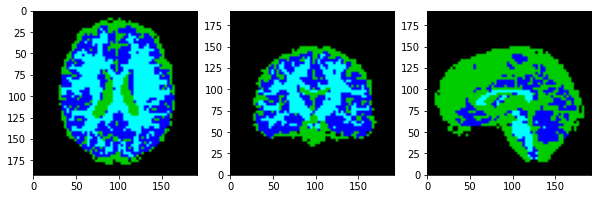

Mask


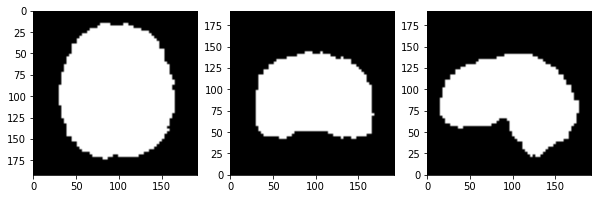

In [17]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [18]:
class SimpleNet3D_original(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D_original, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        return x # cross-entropy loss expects raw logits and applies softmax


In [19]:
########################################
# BUILD A BETTER MODEL HERE
########################################

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.lrelu1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.lrelu2 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.lrelu3 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm3d(128)
        self.lrelu4 = nn.LeakyReLU(0.2)
        self.conv5 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm3d(256)
        self.lrelu5 = nn.LeakyReLU(0.2)
        self.conv6 = nn.Conv3d(256, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm3d(512)
        self.lrelu6 = nn.LeakyReLU(0.2)
        self.conv7 = nn.Conv3d(512, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.lrelu1(self.bn1(self.conv1(x)))
        x = self.lrelu2(self.bn2(self.conv2(x)))
        x = self.lrelu3(self.bn3(self.conv3(x)))
        x = self.lrelu4(self.bn4(self.conv4(x)))
        x = self.lrelu5(self.bn5(self.conv5(x)))
        x = self.lrelu6(self.bn6(self.conv6(x)))

        x = self.conv7(x)
        
        return x # cross-entropy loss expects raw logits and applies softmax

In [20]:
def dice_loss_3D_seg(true, pred, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = pred.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 4, 1, 2, 3).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pred_compact = torch.argmax(pred, dim=1)
        pred_1_hot = torch.eye(num_classes)[pred_compact.squeeze(1)]
        pred_1_hot = pred_1_hot.permute(0, 4, 1, 2, 3).float()
        pred_1_hot_f = pred_1_hot[:, 0:1, :, :]
        pred_1_hot_s = pred_1_hot[:, 1:2, :, :]
        pred_1_hot = torch.cat([pred_1_hot_s, pred_1_hot_f], dim=1)
    
        
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 4, 1, 2, 3).float()
        pred_compact = torch.argmax(pred, dim=1)
        pred_1_hot = torch.eye(num_classes)[pred_compact.squeeze(1)]
        pred_1_hot = pred_1_hot.permute(0, 4, 1, 2, 3).float()
    

    pred_1_hot = pred_1_hot.type(pred.type())
    true_1_hot = true_1_hot.type(pred.type())

    
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(pred_1_hot * true_1_hot, dims)
    cardinality = torch.sum(pred_1_hot + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return dice_loss

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.270529 	Dice Score: 0.634859
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.222628 	Dice Score: 0.744361


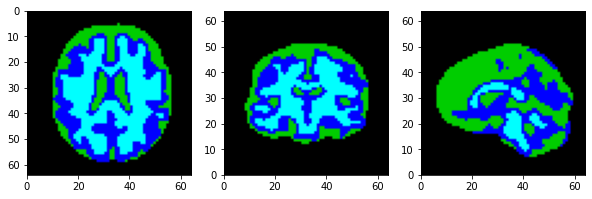

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.178775 	Dice Score: 0.757364
+ TRAINING 	Epoch: 3 	Loss: 0.145223 	Dice Score: 0.781494
+ TRAINING 	Epoch: 4 	Loss: 0.144859 	Dice Score: 0.800975
+ TRAINING 	Epoch: 5 	Loss: 0.182289 	Dice Score: 0.813343
--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 0.139716 	Dice Score: 0.830457


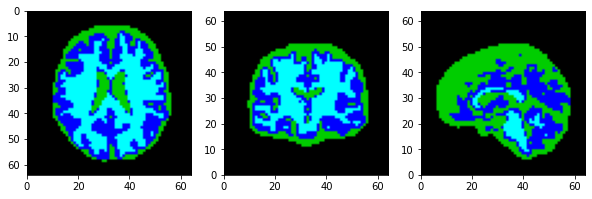

--------------------------------------------------
+ TRAINING 	Epoch: 6 	Loss: 0.140889 	Dice Score: 0.827689
+ TRAINING 	Epoch: 7 	Loss: 0.129059 	Dice Score: 0.826212
+ TRAINING 	Epoch: 8 	Loss: 0.127914 	Dice Score: 0.836345
+ TRAINING 	Epoch: 9 	Loss: 0.122213 	Dice Score: 0.834533
+ TRAINING 	Epoch: 10 	Loss: 0.122744 	Dice Score: 0.836566
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.123763 	Dice Score: 0.850868


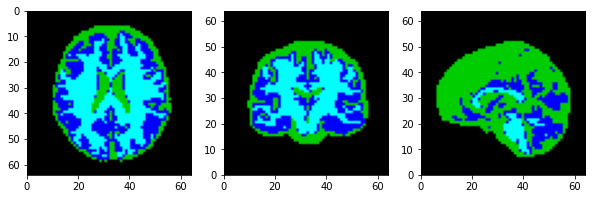

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.109715 	Dice Score: 0.851045
+ TRAINING 	Epoch: 12 	Loss: 0.101502 	Dice Score: 0.857142
+ TRAINING 	Epoch: 13 	Loss: 0.112346 	Dice Score: 0.851807
+ TRAINING 	Epoch: 14 	Loss: 0.108189 	Dice Score: 0.855612
+ TRAINING 	Epoch: 15 	Loss: 0.108745 	Dice Score: 0.862305
--------------------------------------------------
+ VALIDATE 	Epoch: 15 	Loss: 0.114967 	Dice Score: 0.851955


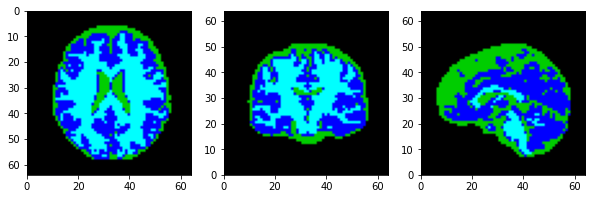

--------------------------------------------------
+ TRAINING 	Epoch: 16 	Loss: 0.105770 	Dice Score: 0.863936
+ TRAINING 	Epoch: 17 	Loss: 0.097762 	Dice Score: 0.864229
+ TRAINING 	Epoch: 18 	Loss: 0.210898 	Dice Score: 0.857577
+ TRAINING 	Epoch: 19 	Loss: 0.092336 	Dice Score: 0.861066
+ TRAINING 	Epoch: 20 	Loss: 0.089295 	Dice Score: 0.870822
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.100973 	Dice Score: 0.876706


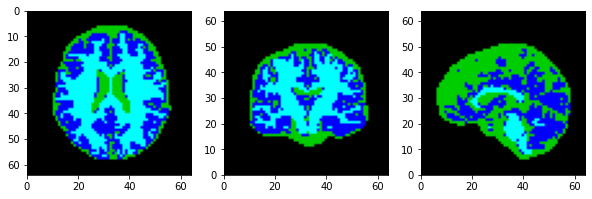

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.134091 	Dice Score: 0.870769
+ TRAINING 	Epoch: 22 	Loss: 0.104481 	Dice Score: 0.874172
+ TRAINING 	Epoch: 23 	Loss: 0.085017 	Dice Score: 0.874736
+ TRAINING 	Epoch: 24 	Loss: 0.114258 	Dice Score: 0.872436
+ TRAINING 	Epoch: 25 	Loss: 0.082501 	Dice Score: 0.876775
--------------------------------------------------
+ VALIDATE 	Epoch: 25 	Loss: 0.098545 	Dice Score: 0.879509


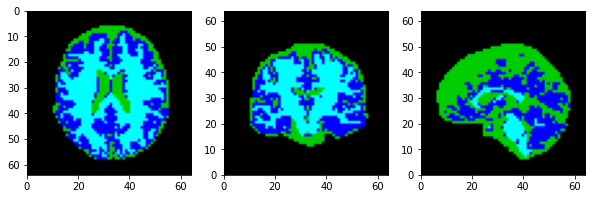

--------------------------------------------------
+ TRAINING 	Epoch: 26 	Loss: 0.099660 	Dice Score: 0.875113
+ TRAINING 	Epoch: 27 	Loss: 0.176171 	Dice Score: 0.878004
+ TRAINING 	Epoch: 28 	Loss: 0.092925 	Dice Score: 0.875367
+ TRAINING 	Epoch: 29 	Loss: 0.087844 	Dice Score: 0.880156
+ TRAINING 	Epoch: 30 	Loss: 0.125605 	Dice Score: 0.877852
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.097754 	Dice Score: 0.881190


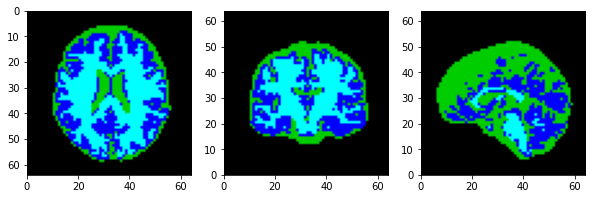

--------------------------------------------------

Finished TRAINING.


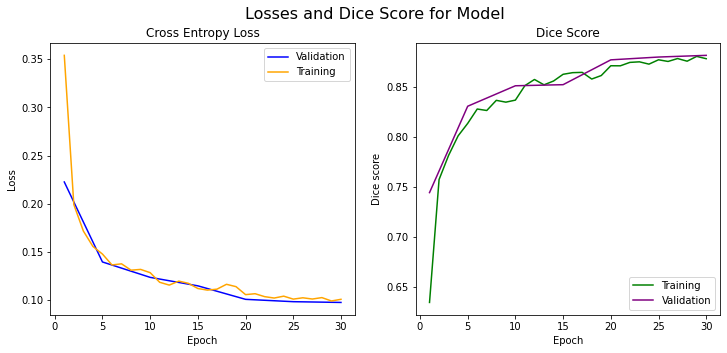

In [21]:
from scipy.ndimage import distance_transform_cdt
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


torch.manual_seed(rnd_seed) #fix random seed

model = SimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
mean_loss_train_log = []
loss_val_log = []
epoch_val_log = []
dice_score_train_log = []
dice_score_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    sum_loss = 0
    dice_sc = 0
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        
        loss.backward()
        optimizer.step()
        #print(seg.shape)
        #print(prd.shape)
        dice_sc += dice_loss_3D_seg(seg.cpu(), prd.cpu())
        sum_loss += loss
        
        
        
        #print(dice_sc)

    
    #print(prd)
    
    #prd = torch.argmax(prd, dim=1)
    avg_dice_sc = dice_sc/(batch_idx+1)
    mean_loss_train_log.append((sum_loss/(batch_idx+1)).item())

    dice_score_train_log.append(avg_dice_sc.item())
    loss_train_log.append(loss.item())
    

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \tDice Score: {:.6f}'.format(epoch, loss.item(), avg_dice_sc.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        dice_sc = 0
        num_samples = 0
        with torch.no_grad():
          
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                dice_sc += dice_loss_3D_seg(seg.cpu(), prd.cpu())
                num_samples += 1
                
        prd = torch.argmax(prd, dim=1)
        
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts
        avg_dice_sc = dice_sc/(num_samples)
        dice_score_val_log.append(avg_dice_sc.item())
        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tDice Score: {:.6f}'.format(epoch, loss_val, avg_dice_sc.item()))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Losses and Dice Score for Model", fontsize=16)

ax[0].set_title('Cross Entropy Loss')
#ax[0].plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
ax[0].plot(epoch_val_log, loss_val_log, c='b', label='Validation')
ax[0].plot(range(1, num_epochs +1), mean_loss_train_log, c = 'orange', label = 'Training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')


ax[1].set_title('Dice Score')
ax[1].plot(range(1, num_epochs +1), dice_score_train_log, c = 'green', label = 'Training')
ax[1].plot(epoch_val_log, dice_score_val_log, c = 'purple', label = 'Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Dice score')
ax[1].legend(loc='lower right')

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 1.120539 	Dice Score: 0.428427
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 1.109190 	Dice Score: 0.445286


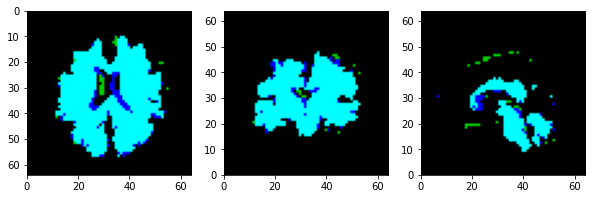

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.896726 	Dice Score: 0.476734
+ TRAINING 	Epoch: 3 	Loss: 0.680674 	Dice Score: 0.603245
+ TRAINING 	Epoch: 4 	Loss: 0.552729 	Dice Score: 0.650117
+ TRAINING 	Epoch: 5 	Loss: 0.425696 	Dice Score: 0.684812
--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 0.425210 	Dice Score: 0.702839


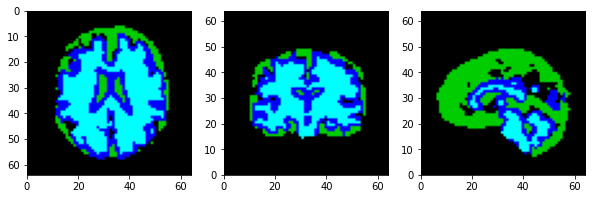

--------------------------------------------------
+ TRAINING 	Epoch: 6 	Loss: 0.376131 	Dice Score: 0.706968
+ TRAINING 	Epoch: 7 	Loss: 0.312751 	Dice Score: 0.716046
+ TRAINING 	Epoch: 8 	Loss: 0.314012 	Dice Score: 0.727193
+ TRAINING 	Epoch: 9 	Loss: 0.301024 	Dice Score: 0.731457
+ TRAINING 	Epoch: 10 	Loss: 0.278264 	Dice Score: 0.740594
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.260835 	Dice Score: 0.749311


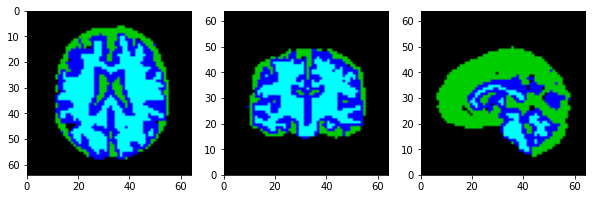

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.231320 	Dice Score: 0.744970
+ TRAINING 	Epoch: 12 	Loss: 0.262093 	Dice Score: 0.747705
+ TRAINING 	Epoch: 13 	Loss: 0.254214 	Dice Score: 0.752833
+ TRAINING 	Epoch: 14 	Loss: 0.248583 	Dice Score: 0.751727
+ TRAINING 	Epoch: 15 	Loss: 0.274636 	Dice Score: 0.759316
--------------------------------------------------
+ VALIDATE 	Epoch: 15 	Loss: 0.224940 	Dice Score: 0.765557


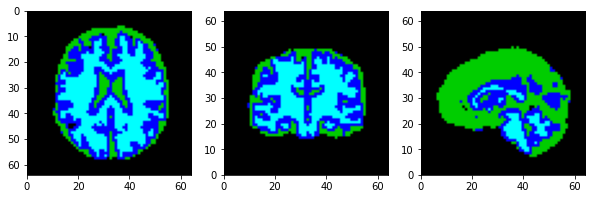

--------------------------------------------------
+ TRAINING 	Epoch: 16 	Loss: 0.242071 	Dice Score: 0.760640
+ TRAINING 	Epoch: 17 	Loss: 0.239298 	Dice Score: 0.764493
+ TRAINING 	Epoch: 18 	Loss: 0.230728 	Dice Score: 0.766738
+ TRAINING 	Epoch: 19 	Loss: 0.230890 	Dice Score: 0.769015
+ TRAINING 	Epoch: 20 	Loss: 0.218187 	Dice Score: 0.769428
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.209042 	Dice Score: 0.775521


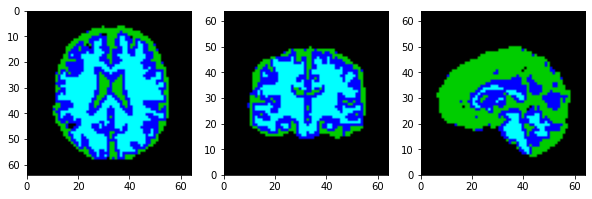

--------------------------------------------------

Finished TRAINING.


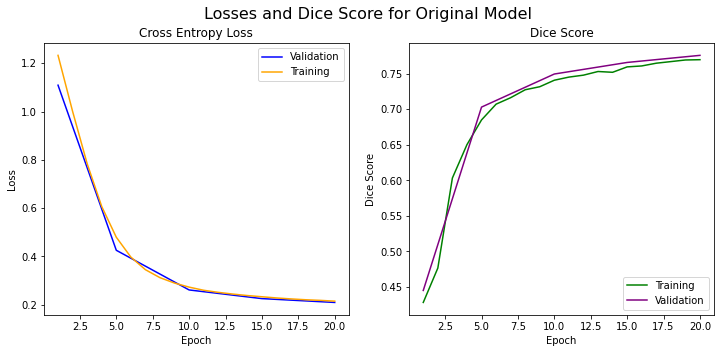

In [22]:
from scipy.ndimage import distance_transform_cdt
model_dir = os.path.join(out_dir, 'model_original')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

num_epochs = 20
torch.manual_seed(rnd_seed) #fix random seed

model_original = SimpleNet3D_original(num_classes=num_classes).to(device)
model_original.train()
    
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=learning_rate)

loss_train_log = []
mean_loss_train_log = []
loss_val_log = []
epoch_val_log = []
dice_score_train_log = []
dice_score_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    sum_loss = 0
    dice_sc = 0
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer_original.zero_grad()
        prd = model_original(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        
        loss.backward()
        optimizer_original.step()
        #print(seg.shape)
        #print(prd.shape)
        dice_sc += dice_loss_3D_seg(seg.cpu(), prd.cpu())
        sum_loss += loss
        
        
        
        #print(dice_sc)

    
    #print(prd)
    
    #prd = torch.argmax(prd, dim=1)
    avg_dice_sc = dice_sc/(batch_idx+1)
    mean_loss_train_log.append((sum_loss/(batch_idx+1)).item())

    dice_score_train_log.append(avg_dice_sc.item())
    loss_train_log.append(loss.item())
    

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \tDice Score: {:.6f}'.format(epoch, loss.item(), avg_dice_sc.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        dice_sc = 0
        num_samples = 0
        with torch.no_grad():
          
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model_original(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                dice_sc += dice_loss_3D_seg(seg.cpu(), prd.cpu())
                num_samples += 1
                
        prd = torch.argmax(prd, dim=1)
        
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts
        avg_dice_sc = dice_sc/(num_samples)
        dice_score_val_log.append(avg_dice_sc.item())
        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tDice Score: {:.6f}'.format(epoch, loss_val, avg_dice_sc.item()))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model_original.state_dict(), os.path.join(model_dir, 'model_original.pt'))

print('\nFinished TRAINING.')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Losses and Dice Score for Original Model", fontsize=16)

ax[0].set_title('Cross Entropy Loss')
#ax[0].plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
ax[0].plot(epoch_val_log, loss_val_log, c='b', label='Validation')
ax[0].plot(range(1, num_epochs +1), mean_loss_train_log, c = 'orange', label = 'Training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')


ax[1].set_title('Dice Score')
ax[1].plot(range(1, num_epochs +1), dice_score_train_log, c = 'green', label = 'Training')
ax[1].plot(epoch_val_log, dice_score_val_log, c = 'purple', label = 'Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Dice Score')
ax[1].legend(loc='lower right')

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [23]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [00:51<00:00,  9.68it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


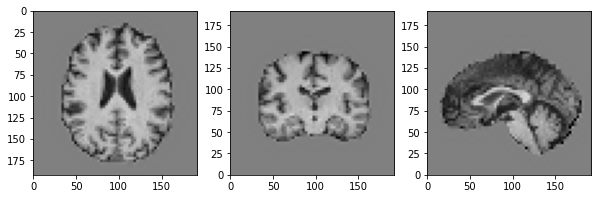

Segmentation


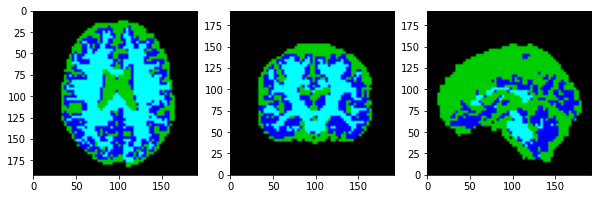

Mask


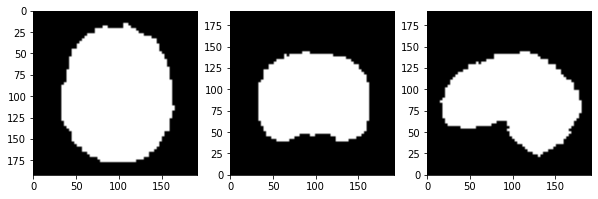

In [24]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

START TESTING...
+ TESTING 	Loss: 0.107124 	Dice Score: 1.744414


Reference segmentation


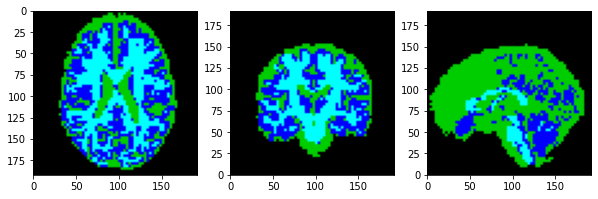

Predicted segmentation


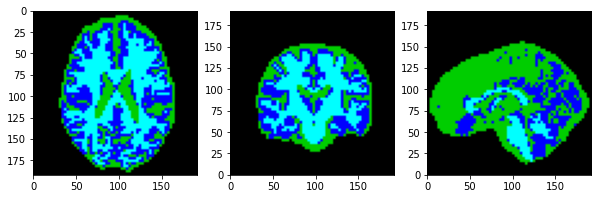


Finished TESTING.
[0.821774215911927, 0.7672978989418473, 0.7625303514376996, 0.7787183387342107, 0.8035390724391842, 0.8001966721010274, 0.7795296812883229, 0.8163290064296979, 0.7761112439782706, 0.7783948269303917, 0.7825893354113326, 0.7655896387184731, 0.7844885088836334, 0.805547089302042, 0.7881669307976756, 0.7627967059583401, 0.7507431762904243, 0.7828907664453831, 0.789059262329051, 0.7814540345464062, 0.796752288160614, 0.7598996731777762, 0.789234065345474, 0.7723934601983382, 0.7588253261770738, 0.7783935855957237, 0.7709679404344347, 0.7912914225758503, 0.760136898892047, 0.7787063537492845, 0.7631957543399726, 0.7887444363416903, 0.7880009250388186, 0.7993956586087815, 0.776262782770375, 0.7830680663731798, 0.743975123088883, 0.742166623312129, 0.7719617660446063, 0.7573076562353457, 0.7898459138946405, 0.776522383701341, 0.807608970931705, 0.7981422146447573, 0.7752733649680216, 0.7863435469996737, 0.80723276839443, 0.7648506618772035, 0.7764545206227808, 0.72895260852

In [27]:
model_dir = os.path.join(out_dir, 'model')
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

SimpleNet3D_model = SimpleNet3D(num_classes=num_classes)
SimpleNet3D_model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
SimpleNet3D_model.to(device)
SimpleNet3D_model.eval()
    
print('START TESTING...')
dice_sc_test = 0
dice_sc_WM_list = []
loss_test = 0
sum_pts = 0
idx_test = 0

CSF_dice_scores = []
GM_dice_scores = []
WM_dice_scores = []

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = SimpleNet3D_model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        dice_sc_test += dice_loss_3D_seg(seg.cpu(), prd.cpu())
        dice_sc_test += dice_loss_3D_seg(seg.cpu(), prd.cpu())
        prd = torch.argmax(prd, dim=1)

        # Metric calculation for each tissue
        overlap_measurer = sitk.LabelOverlapMeasuresImageFilter()
        for n, tissue_dice_score in enumerate([CSF_dice_scores, GM_dice_scores, WM_dice_scores]):
                  
                  # Calculation of DSC for current tissue
                  segmentation_boolean = seg.cpu().squeeze().numpy().astype(np.uint8) == (n+1)
                  prediction_boolean = prd.cpu().squeeze().numpy().astype(np.uint8) == (n+1)
                  segmentation_tissue = segmentation_boolean.astype(int)
                  prediction_tissue = prediction_boolean.astype(int)
                  binary_segmentation_image = sitk.GetImageFromArray(segmentation_tissue)
                  binary_prediction_image = sitk.GetImageFromArray(prediction_tissue)

                  # Saving the DSC
                  overlap_measurer.Execute(binary_segmentation_image, binary_prediction_image)
                  dice_score_sample = overlap_measurer.GetDiceCoefficient()
                  tissue_dice_score.append(dice_score_sample)
        
        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
dice_sc_test /= idx_test

print('+ TESTING \tLoss: {:.6f} \tDice Score: {:.6f}'.format(loss_test, dice_sc_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

print(CSF_dice_scores, GM_dice_scores, WM_dice_scores)

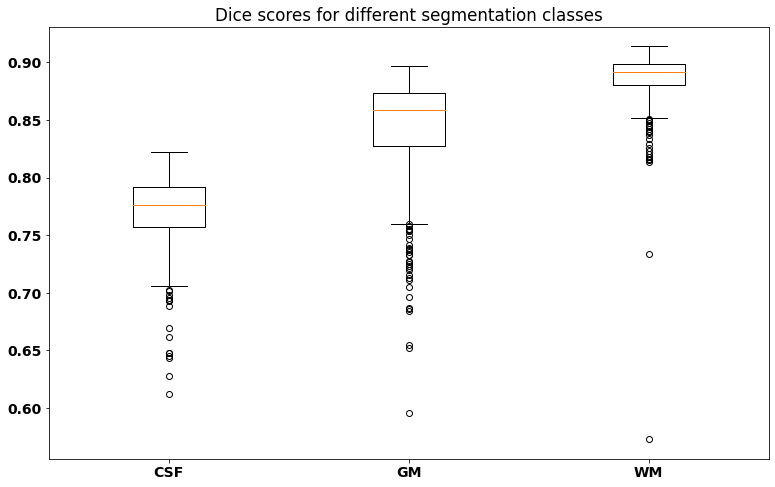

In [28]:
# Box and whisker plot of the dice scores for each segmentation
# each segmentation is a different box
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

dice_scores_seg = [CSF_dice_scores, GM_dice_scores, WM_dice_scores]

fig = plt.figure(figsize =(10, 6))

ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(dice_scores_seg)
ax.set_xticklabels(['CSF', 'GM', 'WM'])
plt.title('Dice scores for different segmentation classes')
plt.show()

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

Calculating Features: 100%|██████████| 500/500 [00:02<00:00, 203.74it/s]


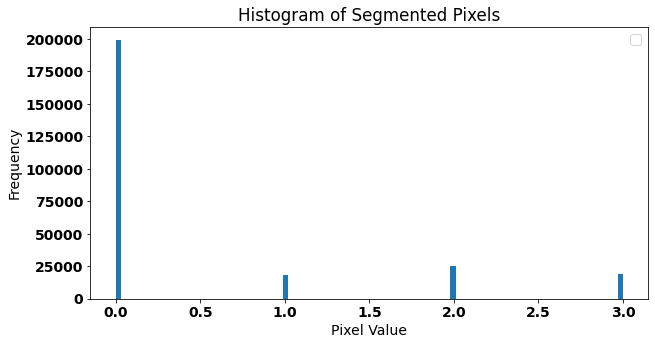

In [29]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))
vols_normalised = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        # calculate the absolute volume of each tissue class
        num_background = np.sum(seg_array == 0)
        num_csf = np.sum(seg_array == 1)
        num_gm = np.sum(seg_array == 2)
        num_wm = np.sum(seg_array == 3)
        # storing the absolute volume of each tissue class in the vols matrix
        vols[0,idx] = num_csf
        vols[1,idx] = num_gm
        vols[2,idx] = num_wm
        # calculate the total volume
        total_volume = num_csf + num_gm + num_wm
        # calculate the relative volume of each tissue class
        relative_background = num_background / total_volume
        relative_csf = num_csf / total_volume
        relative_gm = num_gm / total_volume
        relative_wm = num_wm / total_volume
        # storing the relative volume of each tissue class in the vols matrix
        vols_normalised[0,idx] = relative_csf
        vols_normalised[1,idx] = relative_gm
        vols_normalised[2,idx] = relative_wm
        ########################################
        
# # Plot histogram of Segmented Pixels Values
plt.figure(figsize=(10,5))
plt.hist(seg, bins=100)
plt.title('Histogram of Segmented Pixels')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()




Plot features versus age.

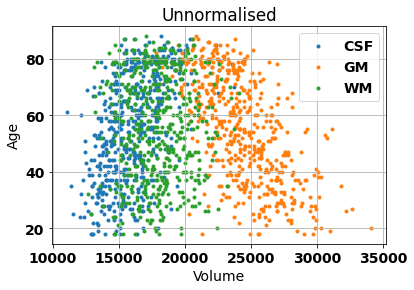

In [30]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Plot normalised features versus age.

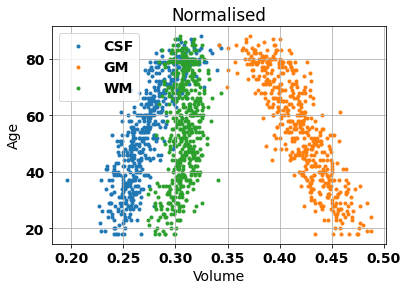

In [31]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [32]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

Linear Regression Results:
---------------------------------
Mean Squared Error: 87.28
R2 Score: 0.74
Mean Absolute Error: 7.45


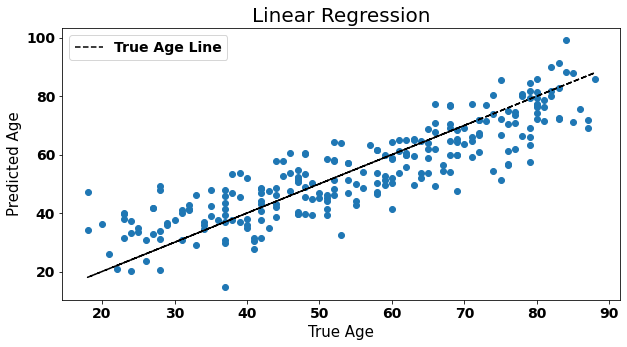

SVM Regression Results:
---------------------------------
Mean Squared Error: 92.23
R2 Score: 0.73
Mean Absolute Error: 7.75


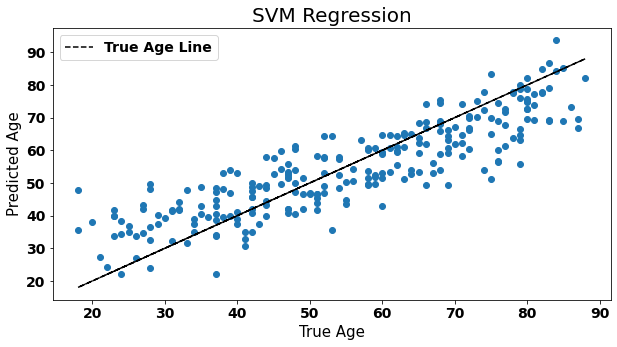

Bayesian Regression Results:
---------------------------------
Mean Squared Error: 87.23
R2 Score: 0.74
Mean Absolute Error: 7.45


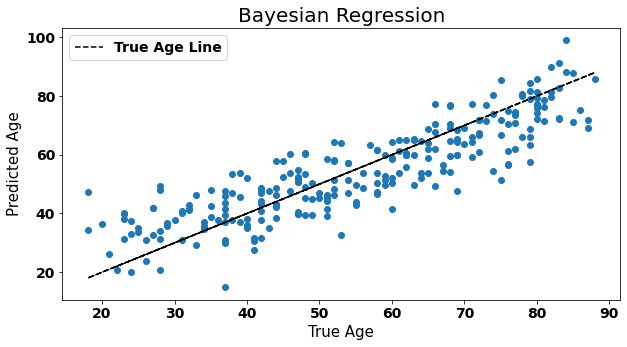

Random Forest Regression Results:
---------------------------------
Mean Squared Error: 83.98
R2 Score: 0.75
Mean Absolute Error: 7.15


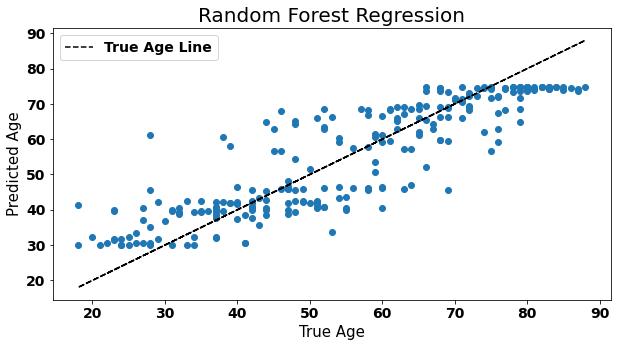

KNN Regression Results:
---------------------------------
Mean Squared Error: 112.29
R2 Score: 0.67
Mean Absolute Error: 8.40


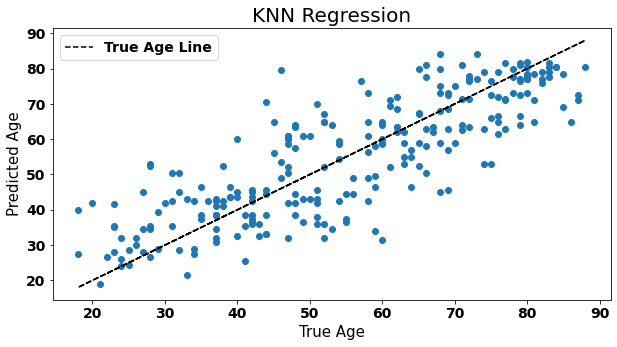

Gaussian Process Regression Results:
---------------------------------
Mean Squared Error: 77.65
R2 Score: 0.77
Mean Absolute Error: 6.87


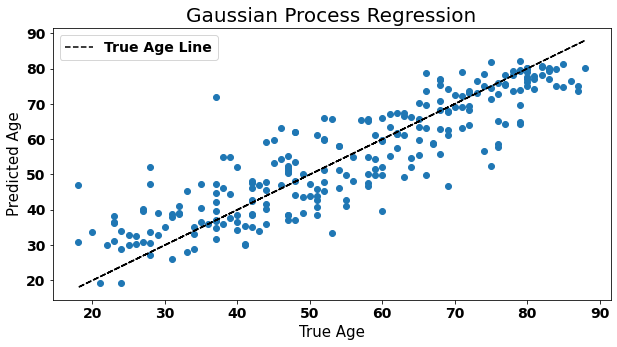

In [33]:
########################################
# ADD YOUR CODE HERE
########################################
# importing libraries
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error


def regressions(X, y, regression_object):
    # two fold cross validation
    kf = KFold(n_splits=2)
    kf.get_n_splits(X)
    # creating empty lists to store the results
    mean_squared_error_list = []
    r2_score_list = []
    mean_absolute_error_list = []
    # iterate over the folds
    for train_index, test_index in kf.split(X):
        # split the data into training and testing sets
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train = y_train.ravel()
        # train the model using the training sets
        regression_object.fit(x_train, y_train)
        # make predictions using the testing set
        y_pred = regression_object.predict(x_test)
        # reshaping the data
        y_test = y_test.reshape(-1,1)
        y_pred = y_pred.reshape(-1,1)
        # calculating metrics
        mse = mean_squared_error(y_test, y_pred)
        mean_squared_error_list.append(mse)
        r2s = r2_score(y_test, y_pred)
        r2_score_list.append(r2s)
        mae = mean_absolute_error(y_test, y_pred)
        mean_absolute_error_list.append(mae)

    return mean_squared_error_list, r2_score_list, mean_absolute_error_list, y_test, y_pred, regression_object


# defining all regression objects
linear_regression = LinearRegression()
svm_regression = SVR(kernel='rbf', C=1e3, gamma=0.1)
bayesian_regression = BayesianRidge()
random_forest_regression = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
knn_regression = KNeighborsRegressor(n_neighbors=2)
gaussian_process_regression = GaussianProcessRegressor()

mse_results = []
r2_results = []
mae_results = []

# saving the trained models
regression_models = []

regression_object_list = [linear_regression, svm_regression, bayesian_regression, random_forest_regression, knn_regression, gaussian_process_regression]
regression_names = ['Linear Regression', 'SVM Regression', 'Bayesian Regression', 'Random Forest Regression', 'KNN Regression', 'Gaussian Process Regression']

for idx, regression_object in enumerate(regression_object_list):
    # get the mean squared error and r2 score
    mean_squared_error_list, r2_score_list, mean_absolute_error_list, y_test, y_pred, regression_model = regressions(X, y, regression_object)
    regression_models.append(regression_model)

    print(f"{regression_names[idx]} Results:")
    print("---------------------------------")
    # print the results
    print(f"Mean Squared Error: {np.mean(mean_squared_error_list):.2f}")
    print(f"R2 Score: {np.mean(r2_score_list):.2f}")
    print(f"Mean Absolute Error: {np.mean(mean_absolute_error_list):.2f}")

    mse_results.append(np.mean(mean_squared_error_list))
    r2_results.append(np.mean(r2_score_list))
    mae_results.append(np.mean(mean_absolute_error_list))

    # plotting resutls
    plt.figure(figsize=(10,5))
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Age', fontsize=15)
    plt.ylabel('Predicted Age', fontsize=15)
    plt.title(f'{regression_names[idx]}', fontsize=20)
    plt.plot(y_test, y_test, color='k', linestyle='dashed', label='True Age Line')
    plt.legend()
    plt.show()

Error calculation and plotting

Regression Results:
---------------------------------


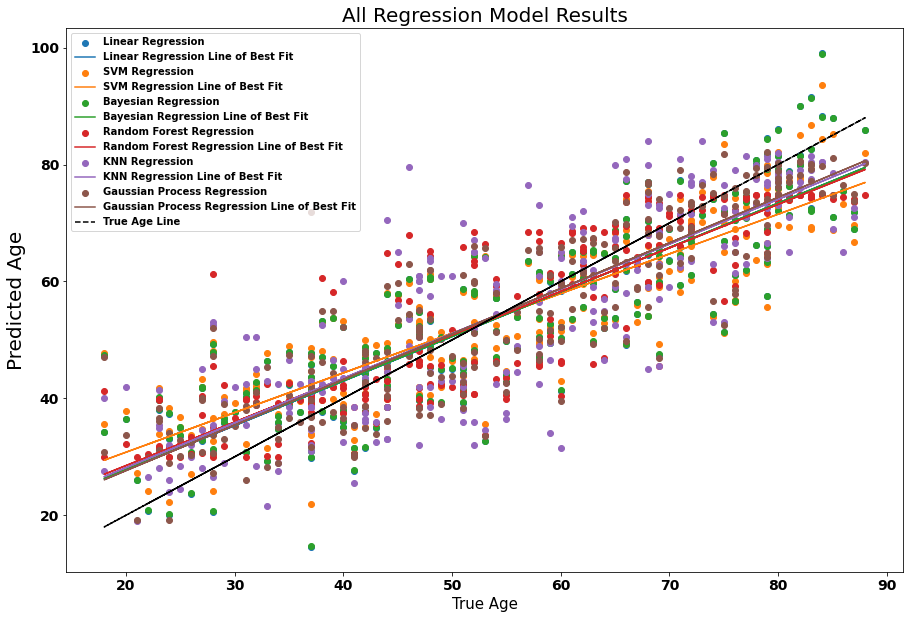

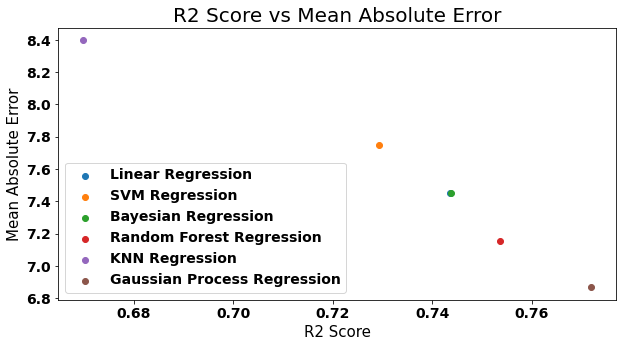

In [42]:
regression_object_list = [linear_regression, svm_regression, bayesian_regression, random_forest_regression, knn_regression, gaussian_process_regression]
regression_names = ['Linear Regression', 'SVM Regression', 'Bayesian Regression', 'Random Forest Regression', 'KNN Regression', 'Gaussian Process Regression']

print(f"Regression Results:")
print("---------------------------------")
plt.figure(figsize=(15,10))

for idx, regression_object in enumerate(regression_object_list):
    # get the mean squared error and r2 score
    mean_squared_error_list, r2_score_list, mean_absolute_error_list, y_test, y_pred, regression_model = regressions(X, y, regression_object)

    # plotting resutls
    plt.scatter(y_test, y_pred, label=f'{regression_names[idx]}')
    a, b = np.polyfit(y_test.ravel(), y_pred.ravel(), 1)
    plt.plot(y_test, a*y_test+b, label = f'{regression_names[idx]} Line of Best Fit')
    plt.xlabel('True Age', fontsize=15)
    plt.ylabel('Predicted Age', fontsize=20)
plt.title(f'All Regression Model Results', fontsize=20)
plt.plot(y_test, y_test, color='k', linestyle='--', label='True Age Line')
plt.legend(fontsize = 10)


plt.figure(figsize=(10,5))
for idx, regression in enumerate(regression_names):
    plt.scatter(r2_results[idx], mae_results[idx], label=f'{regression}')
    plt.xlabel('R2 Score', fontsize=15)
    plt.ylabel('Mean Absolute Error', fontsize=15)
    plt.title(f'R2 Score vs Mean Absolute Error', fontsize=20)
    plt.legend()

### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [37]:
! wget https://www.dropbox.com/s/kk728bfkd5mj0r2/brainage-test-data.zip
! unzip brainage-test-data.zip

--2023-02-27 19:23:00--  https://www.dropbox.com/s/kk728bfkd5mj0r2/brainage-test-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/kk728bfkd5mj0r2/brainage-test-data.zip [following]
--2023-02-27 19:23:01--  https://www.dropbox.com/s/raw/kk728bfkd5mj0r2/brainage-test-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5ed75e76ba3da7a76408995611.dl.dropboxusercontent.com/cd/0/inline/B3SfXwTqJSJnJWYXg4lrawBLZ-9kVzMU28N8sYZAL4CBJM9-hIC8A1xmgsAmymm5Gi7rUv2-DkBiJT9QsCFZrvNfiX0poAkMxrmIm1_x5wM3IQ4AFiEPf4ThcVWl7uefSAhUnKKudsskFJJm21JTMZnE7U3VNs1RLzSlHS6qYbSnXA/file# [following]
--2023-02-27 19:23:01--  https://uc5ed75e76ba3da7a76408995611.dl.dropboxusercontent.com/cd/0/inline/B3SfXwTqJSJnJWYXg4lrawBLZ-9kVzMU28N8sYZAL4CBJM9-hI

#### Loading and pre-processing of testing data

In [38]:
# renaming the data datasets to keep them straight 
# training data of 500 subjects
meta_data_reg_train_500 = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test_500 = list(meta_data_reg_train_500['subject_id'])
files_seg_img_test_500 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test_500]
files_seg_seg_test_500 = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_500]
files_seg_msk_test_500 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test_500]

dataset_test_500 = ImageSegmentationDataset(files_seg_img_test_500, files_seg_seg_test_500, files_seg_msk_test_500, img_spacing, img_size)
dataloader_test_500 = torch.utils.data.DataLoader(dataset_test_500, batch_size=batch_size, shuffle=False)

# training data of 100 subjects
meta_data_reg_test_100 = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test_100 = list(meta_data_reg_test_100['subject_id'])
files_seg_img_test_100 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test_100]
files_seg_seg_test_100 = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_100]
files_seg_msk_test_100 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test_100]

dataset_test_100 = ImageSegmentationDataset(files_seg_img_test_100, files_seg_seg_test_100, files_seg_msk_test_100, img_spacing, img_size)
dataloader_test_100 = torch.utils.data.DataLoader(dataset_test_100, batch_size=batch_size, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


#### Run final testing

retraining the SimpleNet3D model on the whole dataset (500 subjects)...
starting training...
Epoch: 1
+ TRAINING 	Epoch: 1 	Loss: 0.127122 	Dice Score: 0.794393
Epoch: 2
+ TRAINING 	Epoch: 2 	Loss: 0.108298 	Dice Score: 0.854811
Epoch: 3
+ TRAINING 	Epoch: 3 	Loss: 0.102008 	Dice Score: 0.869559
Epoch: 4
+ TRAINING 	Epoch: 4 	Loss: 0.098845 	Dice Score: 0.876000
Epoch: 5
+ TRAINING 	Epoch: 5 	Loss: 0.096597 	Dice Score: 0.879151
Epoch: 6
+ TRAINING 	Epoch: 6 	Loss: 0.095168 	Dice Score: 0.881061
Epoch: 7
+ TRAINING 	Epoch: 7 	Loss: 0.092997 	Dice Score: 0.882595
Epoch: 8
+ TRAINING 	Epoch: 8 	Loss: 0.091509 	Dice Score: 0.884333
Epoch: 9
+ TRAINING 	Epoch: 9 	Loss: 0.090266 	Dice Score: 0.885871
Epoch: 10
+ TRAINING 	Epoch: 10 	Loss: 0.089092 	Dice Score: 0.887099
Epoch: 11
+ TRAINING 	Epoch: 11 	Loss: 0.088059 	Dice Score: 0.888471
Epoch: 12
+ TRAINING 	Epoch: 12 	Loss: 0.086967 	Dice Score: 0.889340
Epoch: 13
+ TRAINING 	Epoch: 13 	Loss: 0.085905 	Dice Score: 0.890856
Epoch: 14
+ TRA

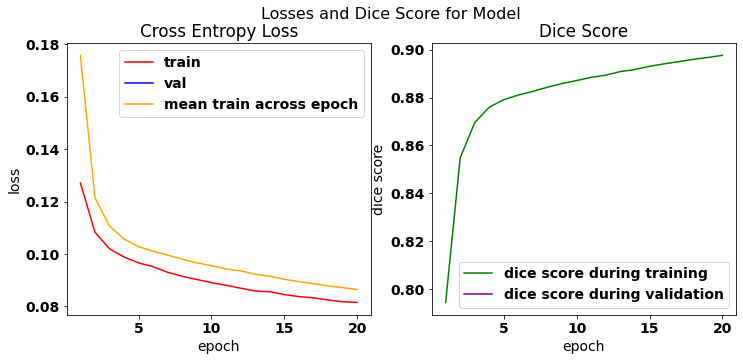

In [40]:
# RETRAINING THE SIMPLENET3D MODEL ON THE WHOLE DATASET (500 subjects) for 20 epochs 
# saving trained model in cnn_model_part_a directory as cnn_model_part_a.pt
print("retraining the SimpleNet3D model on the whole dataset (500 subjects)...")

num_epochs = 20

# creating model directory
from scipy.ndimage import distance_transform_cdt
cnn_model_part_a_dir = os.path.join(out_dir, 'cnn_model_part_a')
if not os.path.exists(cnn_model_part_a_dir):
    os.makedirs(cnn_model_part_a_dir)

torch.manual_seed(rnd_seed) #fix random seed
seg_model = SimpleNet3D(num_classes=num_classes).to(device)
seg_model.train()

optimizer = torch.optim.Adam(seg_model.parameters(), lr=learning_rate)

loss_train_log = []
mean_loss_train_log = []
loss_val_log = []
epoch_val_log = []
dice_score_train_log = []
dice_score_val_log = []
    
print('starting training...')
for epoch in range(1, num_epochs + 1):
    print('Epoch: {}'.format(epoch))

    sum_loss = 0
    dice_sc = 0
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_test_500):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = seg_model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        
        loss.backward()
        optimizer.step()
        dice_sc += dice_loss_3D_seg(seg.cpu(), prd.cpu())
        sum_loss += loss
        
    avg_dice_sc = dice_sc/(batch_idx+1)
    mean_loss_train_log.append((sum_loss/(batch_idx+1)).item())

    dice_score_train_log.append(avg_dice_sc.item())
    loss_train_log.append(loss.item())
    

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \tDice Score: {:.6f}'.format(epoch, loss.item(), avg_dice_sc.item()))
    

torch.save(seg_model.state_dict(), os.path.join(cnn_model_part_a_dir, 'cnn_model_part_a.pt'))

print('\nFinished TRAINING.')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Losses and Dice Score for Model", fontsize=16)

ax[0].set_title('Cross Entropy Loss')
ax[0].plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
ax[0].plot(epoch_val_log, loss_val_log, c='b', label='val')
ax[0].plot(range(1, num_epochs +1), mean_loss_train_log, c = 'orange', label = 'mean train across epoch')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend(loc='upper right')


ax[1].set_title('Dice Score')
ax[1].plot(range(1, num_epochs +1), dice_score_train_log, c = 'green', label = 'dice score during training')
ax[1].plot(epoch_val_log, dice_score_val_log, c = 'purple', label = 'dice score during validation')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('dice score')
ax[1].legend(loc='lower right')

In [43]:
# APPLYING THE SEGMENTATION MODEL TO THE TRAIN DATASET
# utilizing seg model trained on the dataset of 500 subjects (seg_model) to obtain segmentations for the train dataset of 500 subjects
# defining the segmentation model (loading its saved parameters during training)
# saving the segmentations in cnn_segmentations_part_a_train directory
model_dir = os.path.join(out_dir, 'cnn_model_part_a')
seg_model.load_state_dict(torch.load(os.path.join(model_dir, 'cnn_model_part_a.pt')))
seg_model.to(device)
seg_model.eval()

#APPLYING THE SEGMENTATION MODEL TO THE TRAIN DATASET
print('Applying the segmentation model to the training dataset...')
# creating directory to save images
cnn_segmentations_part_a_dir = os.path.join(out_dir, 'cnn_segmentations_part_a_train')
if not os.path.exists(cnn_segmentations_part_a_dir):
    os.makedirs(cnn_segmentations_part_a_dir)

dataloader_test_500 = torch.utils.data.DataLoader(dataset_test_500, batch_size=1, shuffle=False)

idx_test = 0
with torch.no_grad():
    # looping through the test dataset
    for sample_data in dataloader_test_500:
        # get the image and the segmentation
        img, seg, msk = sample_data['img'].to(device), sample_data['seg'].to(device), sample_data['msk'].to(device)
        # segmenting the image
        prd = seg_model(img)
        prd = torch.argmax(prd, dim=1)

        # storing predicted segmentation
        sample = dataset_test_500.get_sample(idx_test)
        name = dataset_test_500.get_seg_name(idx_test)
    
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(cnn_segmentations_part_a_dir, name))

        idx_test += 1  


# OBTAINING TISSUE VOUMES FOR THE WHOLE DATASET (500 subjects)
print('Calculating tissue volumes of the train dataset...')
# making directory to saved test segmentation the results
seg_dir = './output/cnn_segmentations_part_a_train/'
# extracting data
meta_data_reg_test_500 = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv') # meta data for the train dataset
ids_seg_test_500 = list(meta_data_reg_test_500['subject_id'])
files_reg_seg_test_500 = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_500]

# matricies to store volume data
vols = np.zeros((3,len(files_reg_seg_test_500)))
vols_normalised = np.zeros((3,len(files_reg_seg_test_500)))

# iterating through the segmented test dataset
for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test_500)), desc='Calculating Features')):
    # extracting the file name
    seg_filename = files_reg_seg_test_500[idx]
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        # calculate the absolute volume of each tissue class
        num_background = np.sum(seg_array == 0)
        num_csf = np.sum(seg_array == 1)
        num_gm = np.sum(seg_array == 2)
        num_wm = np.sum(seg_array == 3)
        # storing the absolute volume of each tissue class in the vols matrix
        vols[0,idx] = num_csf
        vols[1,idx] = num_gm
        vols[2,idx] = num_wm
        # calculate the total volume
        total_volume = num_csf + num_gm + num_wm
        # calculate the relative volume of each tissue class
        relative_background = num_background / total_volume
        relative_csf = num_csf / total_volume
        relative_gm = num_gm / total_volume
        relative_wm = num_wm / total_volume
        # storing the relative volume of each tissue class in the vols matrix
        vols_normalised[0,idx] = relative_csf
        vols_normalised[1,idx] = relative_gm
        vols_normalised[2,idx] = relative_wm


Applying the segmentation model to the training dataset...
Calculating tissue volumes of the train dataset...


Calculating Features: 100%|██████████| 500/500 [00:02<00:00, 226.79it/s]


retraining the regression model on the whole dataset (500 subjects)...


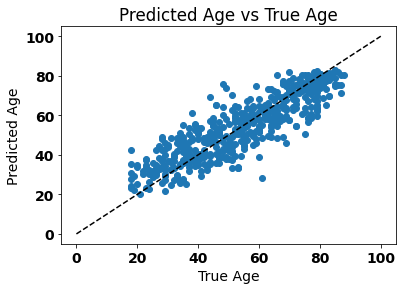

In [44]:
# RETRAINING THE REGRESSION MODEL ON THE WHOLE DATASET (500 subjects) 
print("retraining the regression model on the whole dataset (500 subjects)...")
X = vols_normalised.T
y = meta_data_reg_test_500['age'].values.reshape(-1,1)
# the best model is the random forest
best_regression = GaussianProcessRegressor()
best_regression.fit(X, y.ravel())
y_pred = best_regression.predict(X)

# plotting the results
plt.figure()
plt.scatter(y, y_pred)
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Predicted Age vs True Age')
plt.show()

Applying the segmentation model to the test dataset...
Calculating tissue volumes of the test dataset...


Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 227.22it/s]


Predicting the age of the test dataset using the best regression model...
 
Test Results:
--------------------------
Mean Absolute Error:  7.221417236328125
Mean Squared Error:  77.77616920784116
R2 Score:  0.7943266770279477


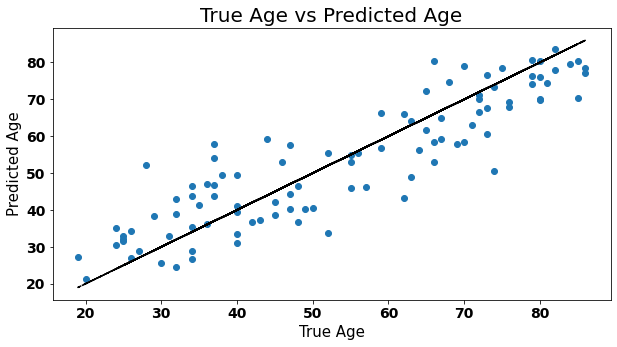

In [45]:
# APPLYING THE SEGMENTATION MODEL TO THE TEST DATASET (100 subjects)
# utilizing seg model trained on the dataset of 500 subjects (seg_model) to obtain segmentations for the test dataset of 100 subjects
# defining the segmentation model (loading its saved parameters during training)
model_dir = os.path.join(out_dir, 'cnn_model_part_a')
seg_model.load_state_dict(torch.load(os.path.join(model_dir, 'cnn_model_part_a.pt')))
seg_model.to(device)
seg_model.eval()

#APPLYING THE SEGMENTATION MODEL TO THE TEST DATASET (100 subjects)
print('Applying the segmentation model to the test dataset...')
# creating directory to save images
cnn_segmentations_part_a_dir = os.path.join(out_dir, 'cnn_segmentations_part_a_test')
if not os.path.exists(cnn_segmentations_part_a_dir):
    os.makedirs(cnn_segmentations_part_a_dir)

dataloader_test_100 = torch.utils.data.DataLoader(dataset_test_100, batch_size=1, shuffle=False)

idx_test = 0
with torch.no_grad():
    # looping through the test dataset
    for sample_data in dataloader_test_100:
        # get the image and the segmentation
        image, segmentation, mask = sample_data['img'].to(device), sample_data['seg'].to(device), sample_data['msk'].to(device)
        # segmenting the image
        predicted_segmentation = seg_model(image)
        predicted_segmentation = torch.argmax(predicted_segmentation, dim=1)

        # storing predicted segmentation
        sample = dataset_test_100.get_sample(idx_test)
        name = dataset_test_100.get_seg_name(idx_test)
        predicted_segmentation = sitk.GetImageFromArray(predicted_segmentation.cpu().squeeze().numpy().astype(np.uint8))
        predicted_segmentation.CopyInformation(sample['seg'])
        sitk.WriteImage(predicted_segmentation, os.path.join(cnn_segmentations_part_a_dir, name))

        idx_test += 1  
    
# CALCULATING TISSUE VOLUMES OF THE TEST DATASET
print('Calculating tissue volumes of the test dataset...')
# making directory to saved test segmentation the results
seg_dir = './output/cnn_segmentations_part_a_test/'
# extracting data
meta_data_reg_test_100 = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test_100 = list(meta_data_reg_test_100['subject_id'])
files_reg_seg_test_100 = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_100]



# matricies to store volume data
vols = np.zeros((3,len(files_reg_seg_test_100)))
vols_normalised = np.zeros((3,len(files_reg_seg_test_100)))

# iterating through the segmented test dataset
for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test_100)), desc='Calculating Features')):
    # extracting the file name
    seg_filename = files_reg_seg_test_100[idx]
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        # calculate the absolute volume of each tissue class
        num_background = np.sum(seg_array == 0)
        num_csf = np.sum(seg_array == 1)
        num_gm = np.sum(seg_array == 2)
        num_wm = np.sum(seg_array == 3)

        # storing the absolute volume of each tissue class in the vols matrix
        vols[0,idx] = num_csf
        vols[1,idx] = num_gm
        vols[2,idx] = num_wm
        # calculate the total volume
        total_volume = num_csf + num_gm + num_wm
        # calculate the relative volume of each tissue class
        relative_background = num_background / total_volume
        relative_csf = num_csf / total_volume
        relative_gm = num_gm / total_volume
        relative_wm = num_wm / total_volume
        # storing the relative volume of each tissue class in the vols matrix
        vols_normalised[0,idx] = relative_csf
        vols_normalised[1,idx] = relative_gm
        vols_normalised[2,idx] = relative_wm

# PREDICTING THE AGE OF THE TEST DATASET USING THE BEST REGRESSION MODEL
print('Predicting the age of the test dataset using the best regression model...')
# defining x and y for the regression
X = vols_normalised.T
y = meta_data_reg_test_100['age'].values.reshape(-1,1)

# predicting the age of the test dataset using the best regression model
y_pred = best_regression.predict(X)

print(" ")
print("Test Results:")
print("--------------------------")
# calculating the mean absolute error
mae = mean_absolute_error(y, y_pred)
print('Mean Absolute Error: ', mae)
# calculating the mean squared error
mse = mean_squared_error(y, y_pred)
print('Mean Squared Error: ', mse)
# calculating the r2 score
r2 = r2_score(y, y_pred)
print('R2 Score: ', r2)

plt.figure(figsize=(10,5))
plt.scatter(y, y_pred)
plt.plot(y, y, color='k', linestyle="dashed")
plt.xlabel('True Age', fontsize=15)
plt.ylabel('Predicted Age', fontsize=15)
plt.title('True Age vs Predicted Age', fontsize=20)
plt.show()

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

In [46]:
# Create the class to define the regression dagtaset
class ImageAge(Dataset):
    """Dataset for age regression from 3D brain scan image ."""

    def __init__(self, file_list_img, file_list_msk, img_spacing, img_size, meta_data):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)
            age = meta_data['age'][idx]
          

            sample = {'img': img, 'age': age}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        #msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)
        age = torch.tensor(sample['age'], dtype = torch.float32)

        return {'img': image, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

In [72]:
 # AGEPREDICTOR NETWORK

# Initial attempt for a regressor network architecture 
import torch
import torch.nn as nn

class AgePredictor(nn.Module):
    def __init__(self):
        super(AgePredictor, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.relu1 = nn.LeakyReLU(inplace=True)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.relu2 = nn.LeakyReLU(inplace=True)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.relu3 = nn.LeakyReLU(inplace=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm3d(256)
        self.relu4 = nn.LeakyReLU(inplace=True)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(4 * 4 * 4 * 256, 1024)
        self.relu5 = nn.LeakyReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 1)
      

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = x.view(-1, 4 * 4 * 4 * 256)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)

        return x

In [77]:
# AGE PREDICTION LeNet NETWORK
class AgePredictionLeNet(nn.Module):
    def __init__(self):
        super(AgePredictionLeNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 12, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm3d(12)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(12, 32, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 2 * 8 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1, bias=True)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool1(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.leaky_relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 2 * 8 * 4)
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [49]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv3 = nn.Conv3d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels * 4)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * 4:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * 4)
            )
        

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(identity)
        out = self.relu(out)
        return out


class ResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(256, 64),
            ResidualBlock(256, 64)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(256, 128, stride=2),
            ResidualBlock(512, 128),
            ResidualBlock(512, 128),
            ResidualBlock(512, 128)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(512, 256, stride=2),
            ResidualBlock(1024, 256),
            ResidualBlock(1024, 256),
            ResidualBlock(1024, 256),
            ResidualBlock(1024, 256),
            ResidualBlock(1024, 256)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(1024, 512, stride=2),
            ResidualBlock(2048, 512),
            ResidualBlock(2048, 512)
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(2048, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    

In [50]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_train = list(meta_data_reg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_val = list(meta_data_seg_train['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

In [51]:
# Define the training loop with cross-validation for the CNN regressor model
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

model_dir = os.path.join(out_dir, 'regressor_CNN')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)



def RegressorNetTraining(dataset, model_name, num_epochs, lr, batch_size, validation_frequency, if_save_model, rnd_seed, model_dir, device):
    # two fold cross validation
    kf = KFold(n_splits=2, shuffle=True, random_state=rnd_seed)
    kf.get_n_splits(dataset)

    fold_loss_train = []
    fold_loss_val = []
    fold_loss_train_additional = []
    fold_loss_val_additional = []
    
    # iterate over the folds
    for fold_idx, (train_index, val_index) in enumerate(kf.split(dataset)):
        
        print('Fold: ', (fold_idx+1))

        # Separate the data into training and validation sets

        train_sampler = SubsetRandomSampler(train_index)
        valid_sampler = SubsetRandomSampler(val_index)
        
        data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        data_loader_val = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)


        # set the random seed
        torch.manual_seed(rnd_seed) #fix random seed
        
        # define the model
        if model_name == 'AgePredictor':
          model = AgePredictor()
        elif model_name == 'ResNet50':
          model = ResNet50()
        elif model_name == 'AgePredictionLeNet':
          model = AgePredictionLeNet()
        model.to(device)
        model.train()
        

        # define the optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

        # initialize the lists for storing the loss values
        loss_train_log = []
        
        loss_val_log = []
        epoch_val_log = []
        MAE_train_log = []
        MAE_val_log =[]
        epoch_val_log = []


        # define the loss function
        criterion = nn.MSELoss() 
        additional_loss = nn.L1Loss()

        print('-------------------------------------------------------------------------------------------------------------------------------------------------')
        print(f'\nStart training the {model_name} model...\n')
        print('-------------------------------------------------------------------------------------------------------------------------------------------------')

        for epoch in range(1, num_epochs+1):

          # TRAINING 
          train_loss = 0.0
          additional_train_loss = 0.0
            

          #loss, add_loss = train_epoch(model, device, data_loader_train, optimizer, criterion, additional_loss)

         
          for batch_idx, data in enumerate(data_loader_train):
            
            # Perform a training step on one batch 
            images = data['img'] 
            labels = data['age'] 
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            #print(output.shape)
            #print(len(output.shape))
            if len(output.shape) > 1:
              output = output.squeeze(1)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            add_l = additional_loss(output,labels)
            additional_train_loss += add_l.item()
        
          loss_train_log.append(train_loss/(batch_idx+1))
          MAE_train_log.append(additional_train_loss/(batch_idx+1))

            

          if epoch % validation_frequency == 0:
                
              # VALIDATION
              with torch.no_grad():
                model.eval()

                valid_loss = 0.0
                additional_valid_loss = 0.0
                model.eval()

                for batch_idx, data in enumerate(data_loader_val):
                  images = data['img'] 
                  labels = data['age'] 
                  images,labels = images.to(device), labels.to(device)
                  output = model(images)
                  if len(output.shape) > 1:
                    output = output.squeeze(1)

                  loss = criterion(output,labels)
                  valid_loss+= loss.item()
                    

                  add_l = additional_loss(output,labels)
                  additional_valid_loss += add_l.item()
    
                
              #loss, add_loss = valid_epoch(model, device, data_loader_val, criterion, additional_loss)
              loss_val_log.append(valid_loss/(batch_idx+1))
              MAE_val_log.append(additional_valid_loss/(batch_idx+1))
              epoch_val_log.append(epoch)

                
              # print the training statistics
              print('-------------------------------------------------------------------------------------------------------------------------------------------------')
              print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining MAE: {:.6f} \tValidation MAE: {:.6f} '.format(
                    epoch, 
                    loss_train_log[-1],
                    loss_val_log[-1],
                    MAE_train_log[-1],
                    MAE_val_log[-1]
                    ))
              print('-------------------------------------------------------------------------------------------------------------------------------------------------')

          else: 
                # print the training statistics
              print('Epoch: {} \tTraining Loss: {:.6f} \tTraining MAE: {:.6f}'.format(
                    epoch, 
                    loss_train_log[-1],
                    MAE_train_log[-1],
                ))
        
        fold_loss_train.append(loss_train_log)
        fold_loss_val.append(loss_val_log)
        fold_loss_train_additional.append(MAE_train_log)
        fold_loss_val_additional.append(MAE_val_log)


    print('-------------------------------------------------------------------------------------------------------------------------------------------------')
    print('\nFinished TRAINING.')
    print('-------------------------------------------------------------------------------------------------------------------------------------------------')

    if if_save_model:
        torch.save(model.state_dict(), os.path.join(model_dir, f"{model_name}.pt"))
        print('-------------------------------------------------------------------------------------------------------------------------------------------------')
        print(f'\n{model_name} model saved in {model_dir}.\n')
        print('-------------------------------------------------------------------------------------------------------------------------------------------------')
    mean_loss_train = np.mean(fold_loss_train, axis=0)
    mean_loss_val = np.mean(fold_loss_val, axis=0)
    mean_MAE_train = np.mean(fold_loss_train_additional, axis=0)
    mean_MAE_val = np.mean(fold_loss_val_additional, axis=0)

    

    return mean_loss_train, mean_loss_val, mean_MAE_train, mean_MAE_val, epoch_val_log



In [52]:
def plot_loss(loss_train_log, MAE_train_log, num_epochs, model_name, if_only_train = False, loss_val_log = None, MAE_val_log = None, epoch_val_log = None):
    if not if_only_train:
      plt.figure(figsize =(10, 6))
      plt.title('MSE Loss for ' + model_name)
      #plt.plot(range(1, num_epochs + 1), loss_train_log_age, c='r', label='train')
      plt.plot(epoch_val_log, loss_val_log, c='b', label='Validation')
      plt.plot(range(1, num_epochs +1), loss_train_log, c = 'orange', label = 'Training')
      plt.xlabel('epoch')
      plt.ylabel('loss')
      plt.legend(loc='upper right')
      plt.show()

      plt.figure(figsize =(10, 6))
      plt.title('MAE Loss for ' + model_name)
      #plt.plot(range(1, num_epochs + 1), loss_train_log_age, c='r', label='train')
      plt.plot(epoch_val_log, MAE_val_log, c='purple', label='Validation')
      plt.plot(range(1, num_epochs +1), MAE_train_log, c = 'green', label = 'Training')
      plt.axhline(y = 7.2214, color='r', linestyle='-', label = 'Part A Model Performance')
      plt.xlabel('epoch')
      plt.ylabel('loss')
      plt.legend(loc='upper right')
      plt.show()
    
    else: 
      plt.figure(figsize =(10, 6))
      plt.title('MSE Loss for ' + model_name)
      #plt.plot(range(1, num_epochs + 1), loss_train_log_age, c='r', label='train')
      plt.plot(range(1, num_epochs +1), loss_train_log, c = 'orange', label = 'Training')
      plt.xlabel('epoch')
      plt.ylabel('loss')
      plt.legend(loc='upper right')
      plt.show()

      plt.figure(figsize =(10, 6))
      plt.title('MAE Loss for ' + model_name)
      #plt.plot(range(1, num_epochs + 1), loss_train_log_age, c='r', label='train')
      plt.plot(range(1, num_epochs +1), MAE_train_log, c = 'green', label = 'Training')
      plt.axhline(y = 7.2214, color='r', linestyle='-', label = 'Part A Model Performance')
      plt.xlabel('epoch')
      plt.ylabel('loss')
      plt.legend(loc='upper right')
      plt.show()



In [53]:
dataset_train_age = ImageAge(files_seg_img_train, files_seg_msk_train, img_spacing, img_size, meta_data_reg_train)

Loading Data: 100%|██████████| 500/500 [00:47<00:00, 10.47it/s]


Fold:  1
-------------------------------------------------------------------------------------------------------------------------------------------------

Start training the AgePredictor model...

-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 	Training Loss: 1542.787421 	Training MAE: 29.040903
Epoch: 2 	Training Loss: 379.688609 	Training MAE: 16.842469
-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 3 	Training Loss: 314.318753 	Validation Loss: 300.945941 	Training MAE: 14.966391 	Validation MAE: 14.514629 
-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 4 	Training Loss: 305.391235 	Training MAE: 14.479067
Epoch: 5 	Training Loss: 249.254394 	Training MAE: 13.227461
-

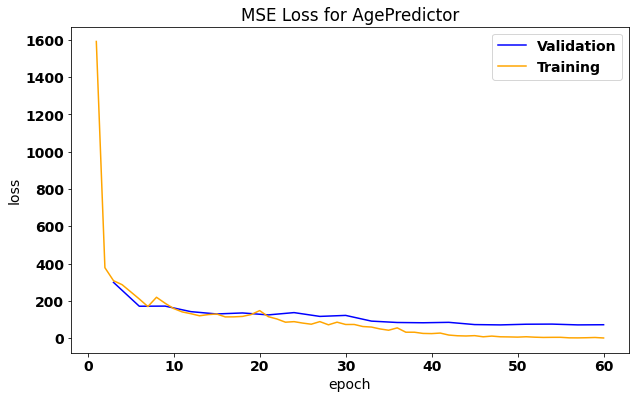

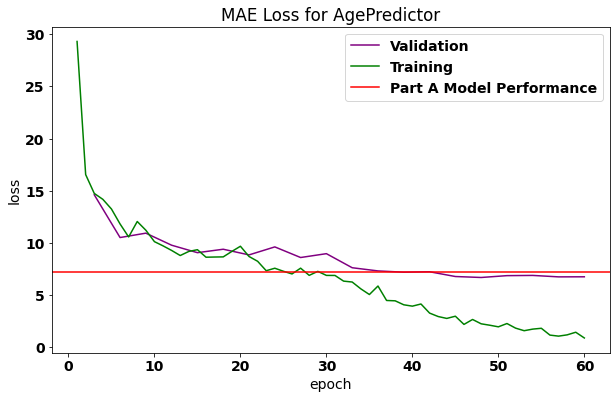

In [83]:
#TRAINING ON DATASET (500 samples, 2-fold cross-validation (50:50))
# Train different previously defined neural networks for regression 
# and plot the loss curves


model_dir = os.path.join(out_dir, 'model_CNN_age_part_b')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

#models = [AgePredictor(), AgePredictionLeNet(), ResNet50(), SegmentorAge(), BrainAGE()]
#model_names = ['AgePredictor', 'AgePredictionLeNet', 'ResNet50', 'SegmentorAge', 'BrainAGE']

model = AgePredictor()

model_name = 'AgePredictor'



num_epochs = 60
batch_size = 15

loss_train_log, loss_val_log, MAE_train_log, MAE_val_log, epoch_val_log = RegressorNetTraining(dataset = dataset_train_age,  
                                                                                                             model_name = model_name, 
                                                                                                             num_epochs=num_epochs, 
                                                                                                             batch_size=batch_size, 
                                                                                                             lr=0.0015, 
                                                                                                             validation_frequency=3, 
                                                                                                             if_save_model=True, 
                                                                                                             model_dir = model_dir, 
                                                                                                             device = device, 
                                                                                                             rnd_seed = rnd_seed)

plot_loss(loss_train_log = loss_train_log, loss_val_log = loss_val_log, MAE_train_log = MAE_train_log, MAE_val_log =  MAE_val_log, num_epochs = num_epochs, epoch_val_log = epoch_val_log, model_name=model_name)

In [ ]:
# Train different previously defined neural networks for regression 
# and plot the loss curves
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
     os.makedirs(model_dir)


model_name = 'ResNet50'

num_epochs = 50
batch_size = 20

loss_train_log, loss_val_log, MAE_train_log, MAE_val_log, epoch_val_log = RegressorNetTraining(dataset = dataset_train_age, 
                                                                                                              model_name = model_name, 
                                                                                                              num_epochs=num_epochs, 
                                                                                                              batch_size=batch_size, 
                                                                                                              lr=0.0001, 
                                                                                                              validation_frequency=5, 
                                                                                                              if_save_model=True, 
                                                                                                              model_dir = model_dir, 
                                                                                                              device = device, 
                                                                                                              rnd_seed = rnd_seed)


Fold:  1
-------------------------------------------------------------------------------------------------------------------------------------------------

Start training the ResNet50 model...

-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 	Training Loss: 2653.514198 	Training MAE: 47.892252
Epoch: 2 	Training Loss: 1670.325646 	Training MAE: 36.958741
Epoch: 3 	Training Loss: 1186.897212 	Training MAE: 31.967124
Epoch: 4 	Training Loss: 861.394902 	Training MAE: 27.810421
-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 5 	Training Loss: 664.493873 	Validation Loss: 181.950038 	Training MAE: 24.413649 	Validation MAE: 11.431937 
-------------------------------------------------------------------------------------------------------------------------------------------------
Epo

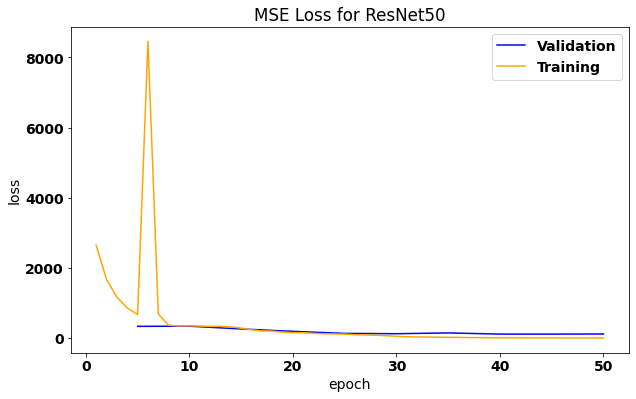

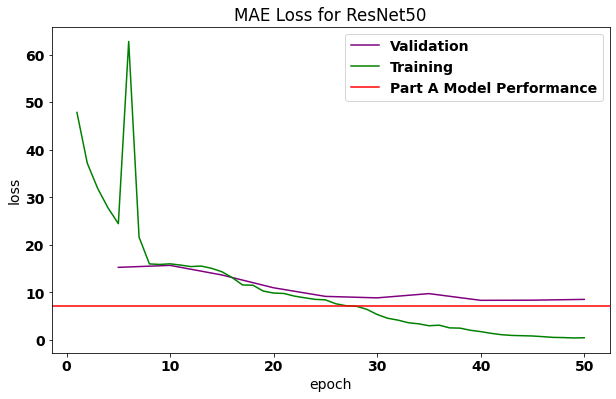

In [75]:
plot_loss(loss_train_log = loss_train_log, loss_val_log = loss_val_log, MAE_train_log = MAE_train_log, MAE_val_log = MAE_val_log, num_epochs= num_epochs, epoch_val_log=epoch_val_log, model_name=model_name)

Fold:  1
-------------------------------------------------------------------------------------------------------------------------------------------------

Start training the AgePredictionLeNet model...

-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 	Training Loss: 894.920897 	Training MAE: 23.637954
Epoch: 2 	Training Loss: 345.541499 	Training MAE: 15.124121
Epoch: 3 	Training Loss: 285.691628 	Training MAE: 13.149234
Epoch: 4 	Training Loss: 323.729130 	Training MAE: 14.526762
-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 5 	Training Loss: 272.179419 	Validation Loss: 244.095609 	Training MAE: 13.520278 	Validation MAE: 13.053960 
----------------------------------------------------------------------------------------------------------------------------------------------

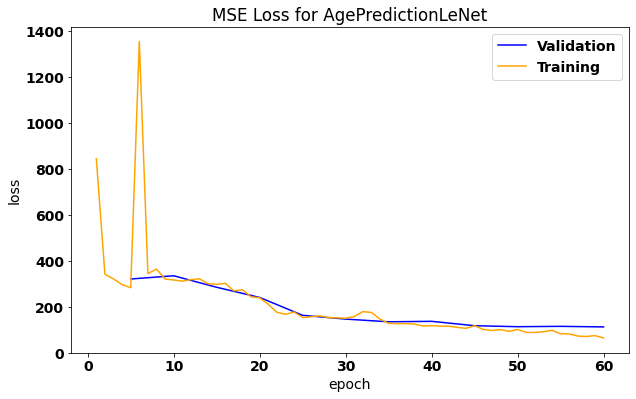

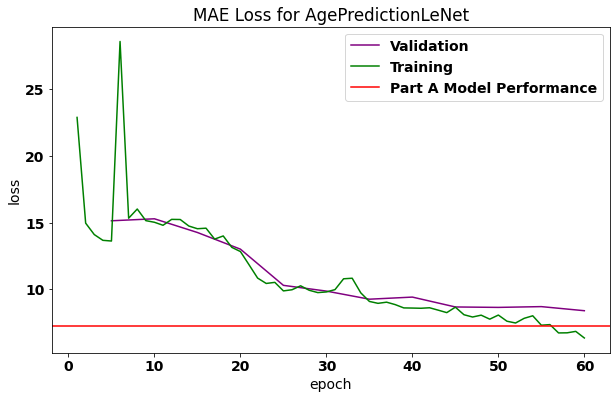

In [78]:
# Train different previously defined neural networks for regression 
# and plot the loss curves
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
     os.makedirs(model_dir)


model_name = 'AgePredictionLeNet'

num_epochs = 60
batch_size = 10

loss_train_log, loss_val_log, MAE_train_log, MAE_val_log, epoch_val_log = RegressorNetTraining(dataset = dataset_train_age, 
                                                                                                              model_name = model_name, 
                                                                                                              num_epochs=num_epochs, 
                                                                                                              batch_size=batch_size, 
                                                                                                              lr=0.001, 
                                                                                                              validation_frequency=5, 
                                                                                                              if_save_model=True, 
                                                                                                              model_dir = model_dir, 
                                                                                                              device = device, 
                                                                                                              rnd_seed = rnd_seed)
plot_loss(loss_train_log = loss_train_log, loss_val_log = loss_val_log, MAE_train_log = MAE_train_log, MAE_val_log = MAE_val_log, num_epochs= num_epochs, epoch_val_log=epoch_val_log, model_name=model_name)

In [84]:
# Define the training loop with cross-validation for the CNN regressor model
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split, SubsetRandomSampler, ConcatDataset

model_dir = os.path.join(out_dir, 'regressor_CNN')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)



def RegressorRetrain(dataset, valid_dataset, model_name, num_epochs, lr, batch_size, if_save_model, rnd_seed, model_dir, device, if_val = True):
        
      # Separate the data into training and validation sets

      
      data_loader_train = DataLoader(dataset, batch_size=batch_size, shuffle = True)
      data_loader_val = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

      # set the random seed
      torch.manual_seed(rnd_seed) #fix random seed
      
      # define the model
      if model_name == 'AgePredictor':
        model = AgePredictor()
      elif model_name == 'ResNet50':
        model = ResNet50()
      elif model_name == 'AgePredictionLeNet':
        model = AgePredictionLeNet()
      model.to(device)
      model.train()
      

      # define the optimizer
      optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

      # initialize the lists for storing the loss values
      loss_train_log = []
      
      loss_val_log = []
      epoch_val_log = []
      MAE_train_log = []
      MAE_val_log =[]
      epoch_val_log = []


      # define the loss function
      criterion = nn.MSELoss() 
      additional_loss = nn.L1Loss()

      print('-------------------------------------------------------------------------------------------------------------------------------------------------')
      print(f'\nStart training the {model_name} model...\n')
      print('-------------------------------------------------------------------------------------------------------------------------------------------------')

      for epoch in range(1, num_epochs+1):

        # TRAINING 
        train_loss = 0.0
        additional_train_loss = 0.0
          

        #loss, add_loss = train_epoch(model, device, data_loader_train, optimizer, criterion, additional_loss)

        
        for batch_idx, data in enumerate(data_loader_train):
          
          # Perform a training step on one batch 
          images = data['img'] 
          labels = data['age'] 
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          output = model(images)
          #print(output.shape)
          #print(len(output.shape))
          if len(output.shape) > 1:
            output = output.squeeze(1)
          loss = criterion(output,labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          add_l = additional_loss(output,labels)
          additional_train_loss += add_l.item()
      
        loss_train_log.append(train_loss/(batch_idx+1))
        MAE_train_log.append(additional_train_loss/(batch_idx+1))

        if if_val: 
          # VALIDATION
          with torch.no_grad():
            model.eval()

            valid_loss = 0.0
            additional_valid_loss = 0.0
            model.eval()

            for batch_idx, data in enumerate(data_loader_val):
              images = data['img'] 
              labels = data['age'] 
              images,labels = images.to(device), labels.to(device)
              output = model(images)
              if len(output.shape) > 1:
                output = output.squeeze(1)

              loss = criterion(output,labels)
              valid_loss+= loss.item()
                

              add_l = additional_loss(output,labels)
              additional_valid_loss += add_l.item()
        
          
          loss_val_log.append(valid_loss/(batch_idx+1))
          MAE_val_log.append(additional_valid_loss/(batch_idx+1))
          epoch_val_log.append(epoch)

            
          # print the training statistics
          print('-------------------------------------------------------------------------------------------------------------------------------------------------')
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining MAE: {:.6f} \tValidation MAE: {:.6f} '.format(
                epoch, 
                loss_train_log[-1],
                loss_val_log[-1],
                MAE_train_log[-1],
                MAE_val_log[-1]
                ))
          print('-------------------------------------------------------------------------------------------------------------------------------------------------')
        else:         
          # print the training statistics
          print('Epoch: {} \tTraining Loss: {:.6f} \tTraining MAE: {:.6f}'.format(
              epoch, 
              loss_train_log[-1],
              MAE_train_log[-1],
          ))

      print('-------------------------------------------------------------------------------------------------------------------------------------------------')
      print('\nFinished TRAINING.')
      print('-------------------------------------------------------------------------------------------------------------------------------------------------')

      if if_save_model:
        torch.save(model.state_dict(), os.path.join(model_dir, f"{model_name}.pt"))
        print('-------------------------------------------------------------------------------------------------------------------------------------------------')
        print(f'\n{model_name} model saved in {model_dir}.\n')
        print('-------------------------------------------------------------------------------------------------------------------------------------------------')
  
      if if_val: 
        return loss_train_log, loss_val_log, MAE_train_log, MAE_val_log, epoch_val_log
      else: 
        return loss_train_log, MAE_train_log



In [88]:
# renaming the data datasets to keep them straight 
# training data of 500 subjects
meta_data_reg_train_500 = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test_500 = list(meta_data_reg_train_500['subject_id'])
files_seg_img_test_500 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test_500]
files_seg_seg_test_500 = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_500]
files_seg_msk_test_500 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test_500]

dataset_test_age_500 = ImageAge(files_seg_img_test_500, files_seg_seg_test_500, img_spacing, img_size, meta_data_reg_train_500)
dataloader_test_age_500 = torch.utils.data.DataLoader(dataset_test_age_500, batch_size=1, shuffle=False)

# training data of 100 subjects
meta_data_reg_test_100 = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test_100 = list(meta_data_reg_test_100['subject_id'])
files_seg_img_test_100 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test_100]
files_seg_seg_test_100 = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_100]
files_seg_msk_test_100 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test_100]

dataset_test_age_100 = ImageAge(files_seg_img_test_100, files_seg_seg_test_100, img_spacing, img_size, meta_data_reg_test_100)
dataloader_test_age_100 = torch.utils.data.DataLoader(dataset_test_age_100, batch_size=batch_size, shuffle=False)


Loading Data: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


In [86]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_valtrain = list(meta_data_seg_train['subject_id'])
files_seg_img_valtrain = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_valtrain]
files_seg_seg_valtrain = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_valtrain]
files_seg_msk_valtrain = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_valtrain]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_valval = list(meta_data_seg_val['subject_id'])
files_seg_img_valval = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_valval]
files_seg_seg_valval = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_valval]
files_seg_msk_valval = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_valval]

In [87]:
# LOAD SECOND VALIDATION DATA (Dataset consisting of 52 brainscans, concatenated from 47 brain images used for training and 5 for validation in Part A)

# We will use it to select the early stopping point during so that the model does not overfit 

dataset_val_segtrain_age = ImageAge(files_seg_img_valtrain, files_seg_msk_valtrain, img_spacing, img_size, meta_data_seg_train)
dataset_val_segval_age= ImageAge(files_seg_img_valval, files_seg_msk_valval, img_spacing, img_size, meta_data_seg_val)
val_datasets = torch.utils.data.ConcatDataset([dataset_val_segtrain_age, dataset_val_segval_age])

Loading Data: 100%|██████████| 5/5 [00:00<00:00, 10.31it/s]


In [89]:
# RETRAINING THE AGE PREDICTOR MODEL ON THE 500 SUBJECTS AND SELECTING THE EARLY STOPPING POINT 
model_dir = os.path.join(out_dir, 'model_CNN_age_part_b_test')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model = AgePredictor()
model_name = 'AgePredictor'
num_epochs = 60
batch_size = 15

loss_train_log, loss_val_log, MAE_train_log, MAE_val_log, epoch_val_log = RegressorRetrain(dataset = dataset_test_age_500, 
                                                                                          valid_dataset = val_datasets, # we are using the second validation dataset for stop point selection
                                                                                          model_name = model_name, 
                                                                                          num_epochs=num_epochs, 
                                                                                          batch_size=batch_size, 
                                                                                          lr=0.0015, 
                                                                                          if_save_model=True, 
                                                                                          model_dir = model_dir, 
                                                                                          device = device, 
                                                                                          rnd_seed = rnd_seed, 
                                                                                          if_val = True)




-------------------------------------------------------------------------------------------------------------------------------------------------

Start training the AgePredictor model...

-------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 	Training Loss: 1042.901307 	Validation Loss: 298.395519 	Training MAE: 22.729987 	Validation MAE: 14.899944 
-------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 	Training Loss: 368.290868 	Validation Loss: 270.932037 	Training MAE: 15.915100 	Validation MAE: 1

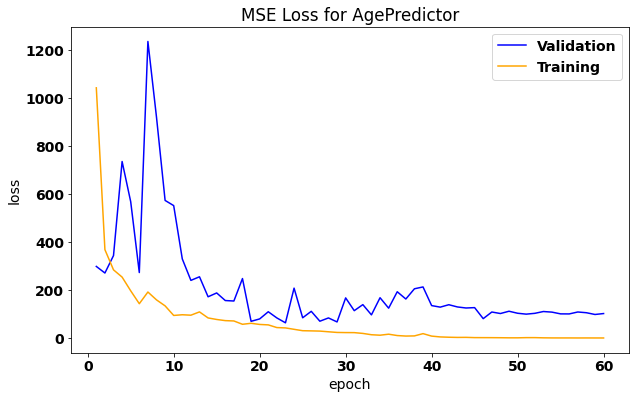

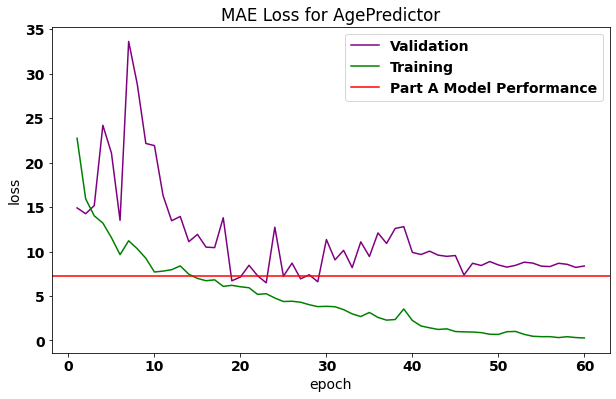

In [90]:
plot_loss(loss_train_log = loss_train_log, loss_val_log = loss_val_log, MAE_train_log = MAE_train_log, MAE_val_log = MAE_val_log, epoch_val_log = epoch_val_log, num_epochs= num_epochs, model_name=model_name)

In [220]:
dataloader_test_age_100 = torch.utils.data.DataLoader(dataset_test_age_100, batch_size=batch_size, shuffle=False)

In [91]:
# RETRAINING THE AGE PREDICTOR MODEL ON THE 500 SUBJECTS AFTER PICKING A EARLY STOPPING POINT EPOCH = 23
model_dir = os.path.join(out_dir, 'model_CNN_age_part_b_test')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model = AgePredictor()
model_name = 'AgePredictor'
num_epochs = 23 # Early stopping point based on the model's performance on second validation set (52 samples)
batch_size = 10

loss_train_log,  MAE_train_log = RegressorRetrain(dataset = dataset_test_age_500, 
                                                  valid_dataset = val_datasets,
                                                  model_name = model_name, 
                                                  num_epochs=num_epochs, 
                                                  batch_size=10, 
                                                  lr=0.0015, 
                                                  if_save_model=True, 
                                                  model_dir = model_dir, 
                                                  device = device, 
                                                  rnd_seed = rnd_seed, 
                                                  if_val = False)


-------------------------------------------------------------------------------------------------------------------------------------------------

Start training the AgePredictor model...

-------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 	Training Loss: 811.474865 	Training MAE: 21.073928
Epoch: 2 	Training Loss: 292.536737 	Training MAE: 14.372306
Epoch: 3 	Training Loss: 195.932865 	Training MAE: 11.485963
Epoch: 4 	Training Loss: 138.046138 	Training MAE: 9.389046
Epoch: 5 	Training Loss: 132.553991 	Training MAE: 9.217202
Epoch: 6 	Training Loss: 107.162326 	Training MAE: 8.354047
Epoch: 7 	Training Loss: 131.587059 	Training MAE: 9.144193
Epoch: 8 	Training Loss: 90.360038 	Training MAE: 7.595925
Epoch: 9 	Training Loss: 81.225406 	Training MAE: 7.124200
Epoch: 10 	Training Loss: 99.072508 	Training MAE: 8.137690
Epoch: 11 	Training Loss: 71.863190 	Training MAE: 6.701588
Epoc

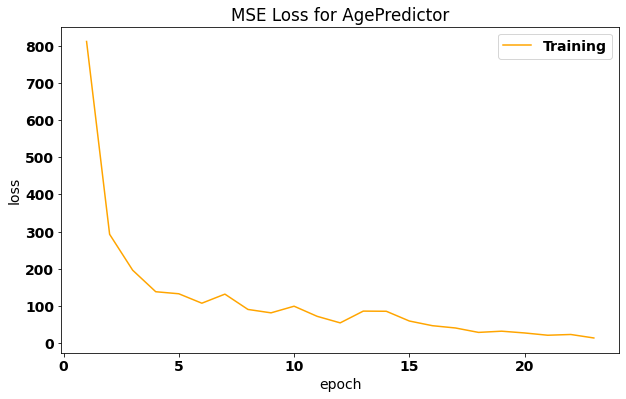

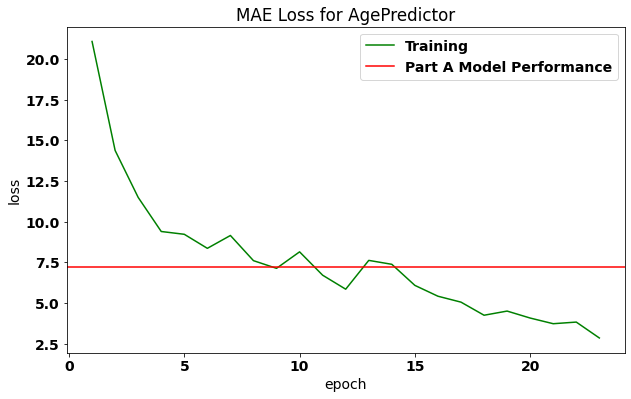

In [92]:
plot_loss(loss_train_log = loss_train_log, MAE_train_log = MAE_train_log, num_epochs= num_epochs, model_name=model_name, if_only_train = True)

START TESTING...
 
Test Results:
--------------------------
Mean Absolute Error: 6.298898662839617
Mean Squared Error: 64.20944254738944
R2 Score: 0.7866758985448532

+ TESTING 	MSE_Loss: 64.20944254738944 	MAE_Loss: 6.298899

Finished TESTING.


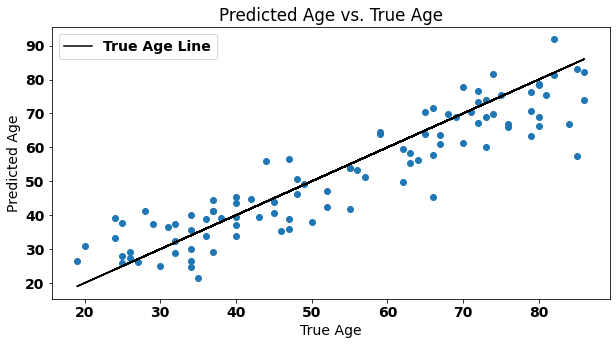

In [94]:
from sklearn.metrics import mean_squared_error, r2_score

model_CNN_age_test = AgePredictor()
model_dir = os.path.join(out_dir, 'model_CNN_age_part_b_test')
model_CNN_age_test.load_state_dict(torch.load(os.path.join(model_dir, 'AgePredictor.pt')))
model_CNN_age_test.to(device)
model_CNN_age_test.eval()
    
print('START TESTING...')
absolute_error_list = []
predicted_age_list = []
MSE_list = []
r2s_list = []

with torch.no_grad():
    for idx, data_sample in enumerate(dataloader_test_age_100):
        img = data_sample['img'].to(device)
        age = data_sample['age'].to(device)
        age_prediction = model_CNN_age_test(img)
        predicted_age_list.extend(age_prediction.cpu().numpy())
        # calculating loss
        absolute_error_list.append(F.l1_loss(age_prediction.squeeze(1), age).item())
        MSE_list.append(F.mse_loss(age_prediction.squeeze(1), age).item())
        r2s_list.append(r2_score(age_prediction.squeeze(1).cpu().numpy(), age.cpu().numpy()))


print(" ")
print("Test Results:")
print("--------------------------")
# calculate mean absolute error
mae = np.mean(absolute_error_list)
print(f"Mean Absolute Error: {mae}")
# calculate mean squared error
mse = np.mean(MSE_list)
print(f"Mean Squared Error: {mse}")
# calculate root mean squared error
y = meta_data_reg_test_100['age'].values
r2s = np.mean(r2s_list)
print(f"R2 Score: {r2s}")

print("")
print('+ TESTING \tMSE_Loss: {} \tMAE_Loss: {:.6f}'.format(mse, mae))

print('\nFinished TESTING.')

# plotting the results
plt.figure(figsize=(10, 5))
plt.title('Predicted Age vs. True Age')
plt.scatter(meta_data_reg_test_100['age'].values, predicted_age_list)
plt.plot(meta_data_reg_test_100['age'].values, meta_data_reg_test_100['age'].values, c='k', label='True Age Line')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()